In [ ]:
import os, types
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample

file_path = '/Final_dataset_Classific.xlsx'
dataset = pd.read_excel(file_path)

In [69]:
cols_to_drop = dataset.filter(like='Medication_').columns
dataset = dataset.drop(columns=cols_to_drop)

In [70]:
# Initial data analysis
missing_values = dataset.isnull().sum()
missing_values_percentage = (missing_values / len(dataset)) * 100
missing_data_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_values_percentage})

# Define features X and target y
X = dataset.drop(columns=['Outcome_numerical'])
y = dataset['Outcome_numerical']

In [71]:
# Split the scaled data into training and testing sets before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.45, random_state=42)
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE only on the training data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_sm))

Before SMOTE: Counter({1: 149, 0: 79, 2: 30})
After SMOTE: Counter({1: 149, 0: 149, 2: 149})


2/2 [==============================] - 0s 6ms/step
Overall Accuracy: 0.7277
Overall Confusion Matrix:
[[ 84  38  20]
 [ 34 234   5]
 [ 23   8  24]]


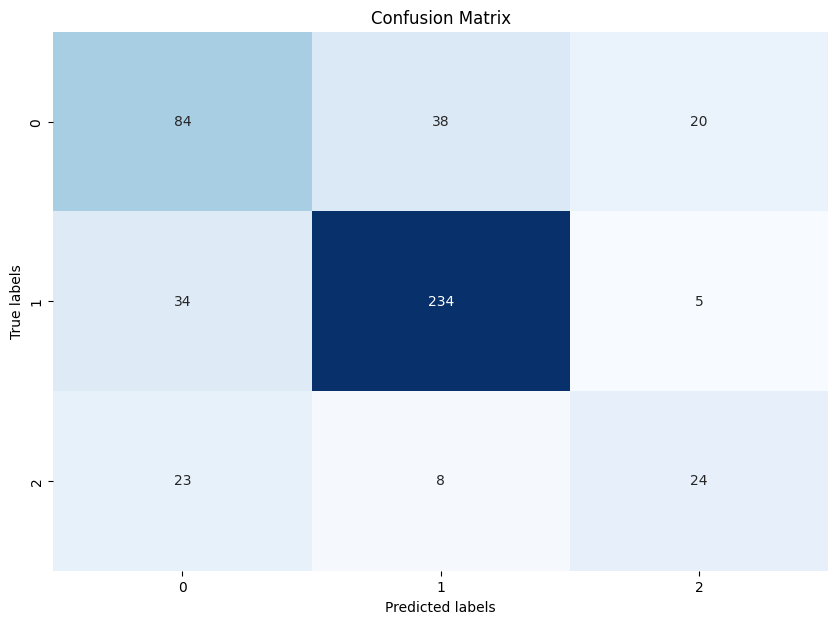

In [ ]:
# Function to build the model
def build_model(input_dim, dropout_rate=0.2, optimizer='adam'):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# K-fold cross-validation parameters
n_splits = 10
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Variables to store aggregated results
all_true_labels = []
all_pred_labels = []
total_scores = []

# Perform k-fold cross-validation
for train_idx, test_idx in kfold.split(X, y):
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X.iloc[train_idx])
    X_test_fold = scaler.transform(X.iloc[test_idx])
    smote = SMOTE(random_state=42)
    X_train_fold_sm, y_train_fold_sm = smote.fit_resample(X_train_fold, y.iloc[train_idx])

    model = build_model(input_dim=X_train_fold_sm.shape[1], dropout_rate=0.2, optimizer='adam')
    model.fit(X_train_fold_sm, y_train_fold_sm, epochs=10, batch_size=32, verbose=0)

    y_pred = np.argmax(model.predict(X_test_fold), axis=1)
    scores = accuracy_score(y.iloc[test_idx], y_pred)
    total_scores.append(scores)

    all_true_labels.extend(y.iloc[test_idx])
    all_pred_labels.extend(y_pred)

# Calculate overall metrics
overall_accuracy = np.mean(total_scores)
overall_confusion_matrix = confusion_matrix(all_true_labels, all_pred_labels)

# Output results
print(f'Overall Accuracy: {overall_accuracy:.4f}')
print('Overall Confusion Matrix:')
print(overall_confusion_matrix)

# Visualization of the Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(overall_confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


2/2 [==============================] - 0s 6ms/step


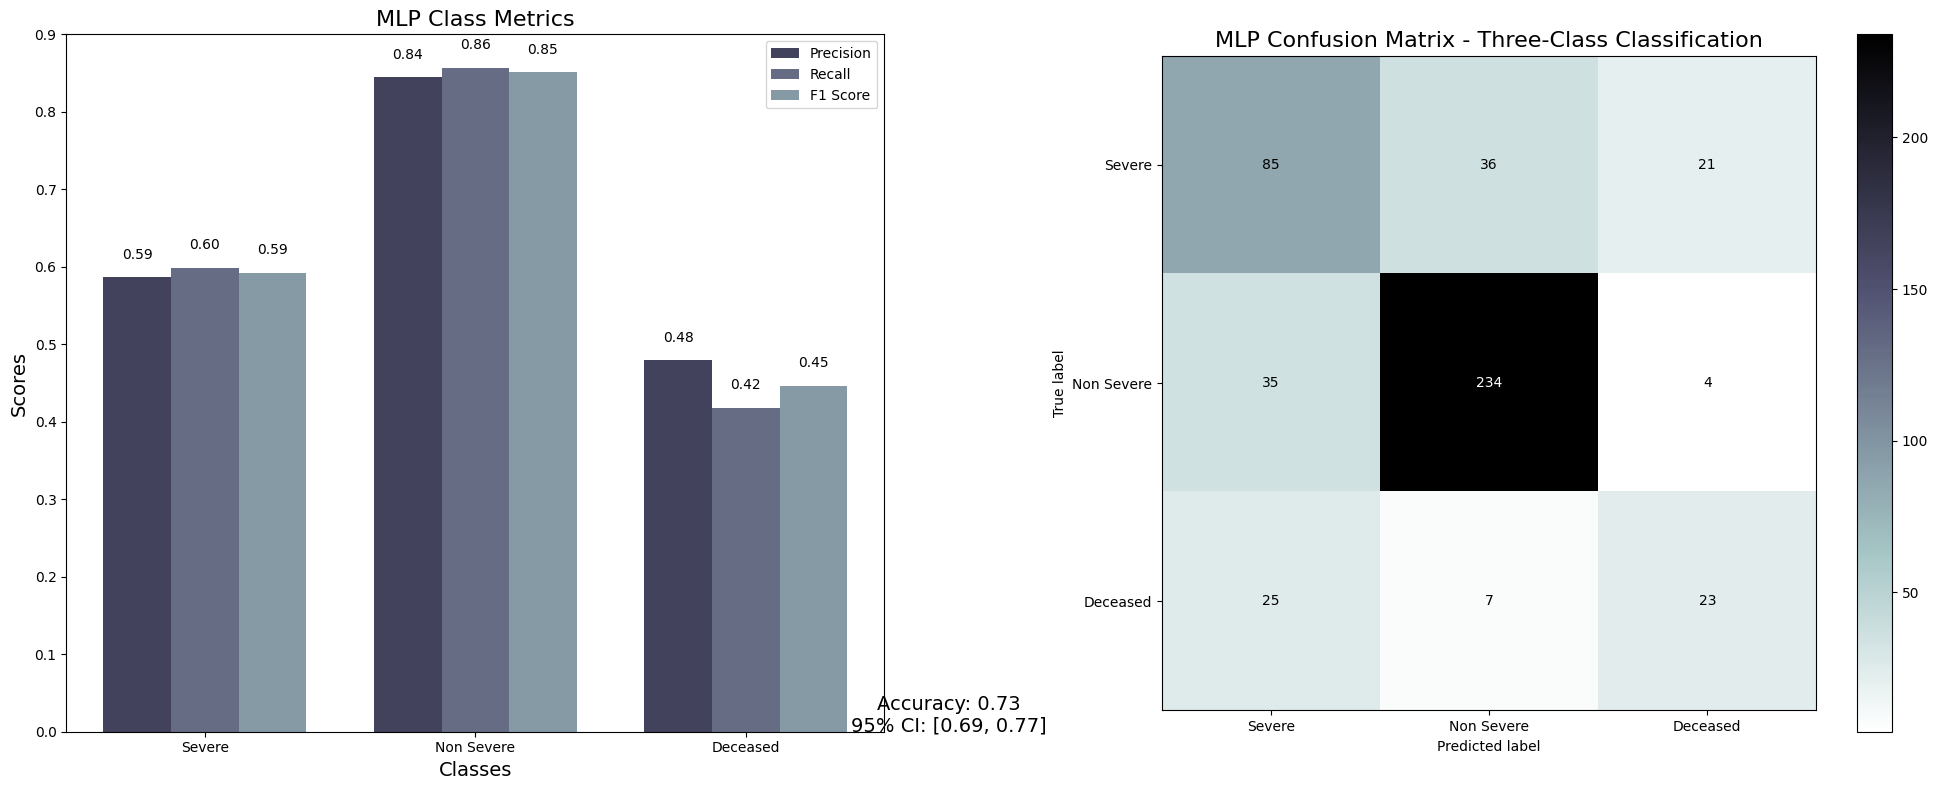

In [ ]:
# Function to build the model
def build_model(input_dim, dropout_rate=0.2, optimizer='adam'):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Bootstrap function for calculating CI of accuracy
def bootstrap_accuracy(y_true, y_pred, n_iterations=1000):
    bootstrap_accuracies = []
    for i in range(n_iterations):
        indices = resample(np.arange(len(y_true)), replace=True)
        sampled_y_true = y_true[indices]
        sampled_y_pred = y_pred[indices]
        bootstrap_accuracies.append(accuracy_score(sampled_y_true, sampled_y_pred))
    return np.percentile(bootstrap_accuracies, [2.5, 97.5])

# K-fold cross-validation parameters
n_splits = 10
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Variables to store aggregated results
all_true_labels = []
all_pred_labels = []
total_scores = []

# Perform k-fold cross-validation
for train_idx, test_idx in kfold.split(X, y):
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X.iloc[train_idx])
    X_test_fold = scaler.transform(X.iloc[test_idx])
    smote = SMOTE(random_state=42)
    X_train_fold_sm, y_train_fold_sm = smote.fit_resample(X_train_fold, y.iloc[train_idx])

    model = build_model(input_dim=X_train_fold_sm.shape[1])
    model.fit(X_train_fold_sm, y_train_fold_sm, epochs=10, batch_size=32, verbose=0)

    y_pred = np.argmax(model.predict(X_test_fold), axis=1)
    scores = accuracy_score(y.iloc[test_idx], y_pred)
    total_scores.append(scores)

    all_true_labels.extend(y.iloc[test_idx])
    all_pred_labels.extend(y_pred)

# Calculate overall metrics
overall_accuracy = np.mean(total_scores)
overall_precision = precision_score(all_true_labels, all_pred_labels, average=None)
overall_recall = recall_score(all_true_labels, all_pred_labels, average=None)
overall_f1 = f1_score(all_true_labels, all_pred_labels, average=None)
overall_confusion_matrix = confusion_matrix(all_true_labels, all_pred_labels)
# Calculate 95% Confidence Interval for the overall accuracy
confidence_interval = bootstrap_accuracy(np.array(all_true_labels), np.array(all_pred_labels))
# Visualization
class_labels = ['Severe', 'Non Severe', 'Deceased']
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
bone_palette = plt.cm.bone(np.linspace(0.3, 0.6, 3))

# Plotting metrics
bar_width = 0.25
index = np.arange(len(class_labels))

axes[0].bar(index, overall_precision, bar_width, color=bone_palette[0], label='Precision')
axes[0].bar(index + bar_width, overall_recall, bar_width, color=bone_palette[1], label='Recall')
axes[0].bar(index + 2 * bar_width, overall_f1, bar_width, color=bone_palette[2], label='F1 Score')

axes[0].set_xlabel('Classes', fontsize=14)
axes[0].set_ylabel('Scores', fontsize=14)
axes[0].set_title('MLP Class Metrics', fontsize=16)
axes[0].set_xticks(index + bar_width)
axes[0].set_xticklabels(class_labels)
axes[0].legend()

# Adding text annotations for clarity
for i in range(len(class_labels)):
    axes[0].text(i, overall_precision[i] + 0.02, f'{overall_precision[i]:.2f}', ha='center', va='bottom')
    axes[0].text(i + bar_width, overall_recall[i] + 0.02, f'{overall_recall[i]:.2f}', ha='center', va='bottom')
    axes[0].text(i + 2 * bar_width, overall_f1[i] + 0.02, f'{overall_f1[i]:.2f}', ha='center', va='bottom')

# Adding CI and overall accuracy to the plot
axes[0].text(len(class_labels), 0, f'Accuracy: {overall_accuracy:.2f}\n95% CI: [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]', fontsize=14, ha='center')

# Confusion Matrix Display
conf_matrix_disp = ConfusionMatrixDisplay(confusion_matrix=overall_confusion_matrix, display_labels=class_labels)
conf_matrix_disp.plot(cmap=plt.cm.bone_r, ax=axes[1], colorbar=True)
axes[1].set_title('MLP Confusion Matrix - Three-Class Classification', fontsize=16)

plt.tight_layout()
plt.show()


2/2 [==============================] - 0s 6ms/step


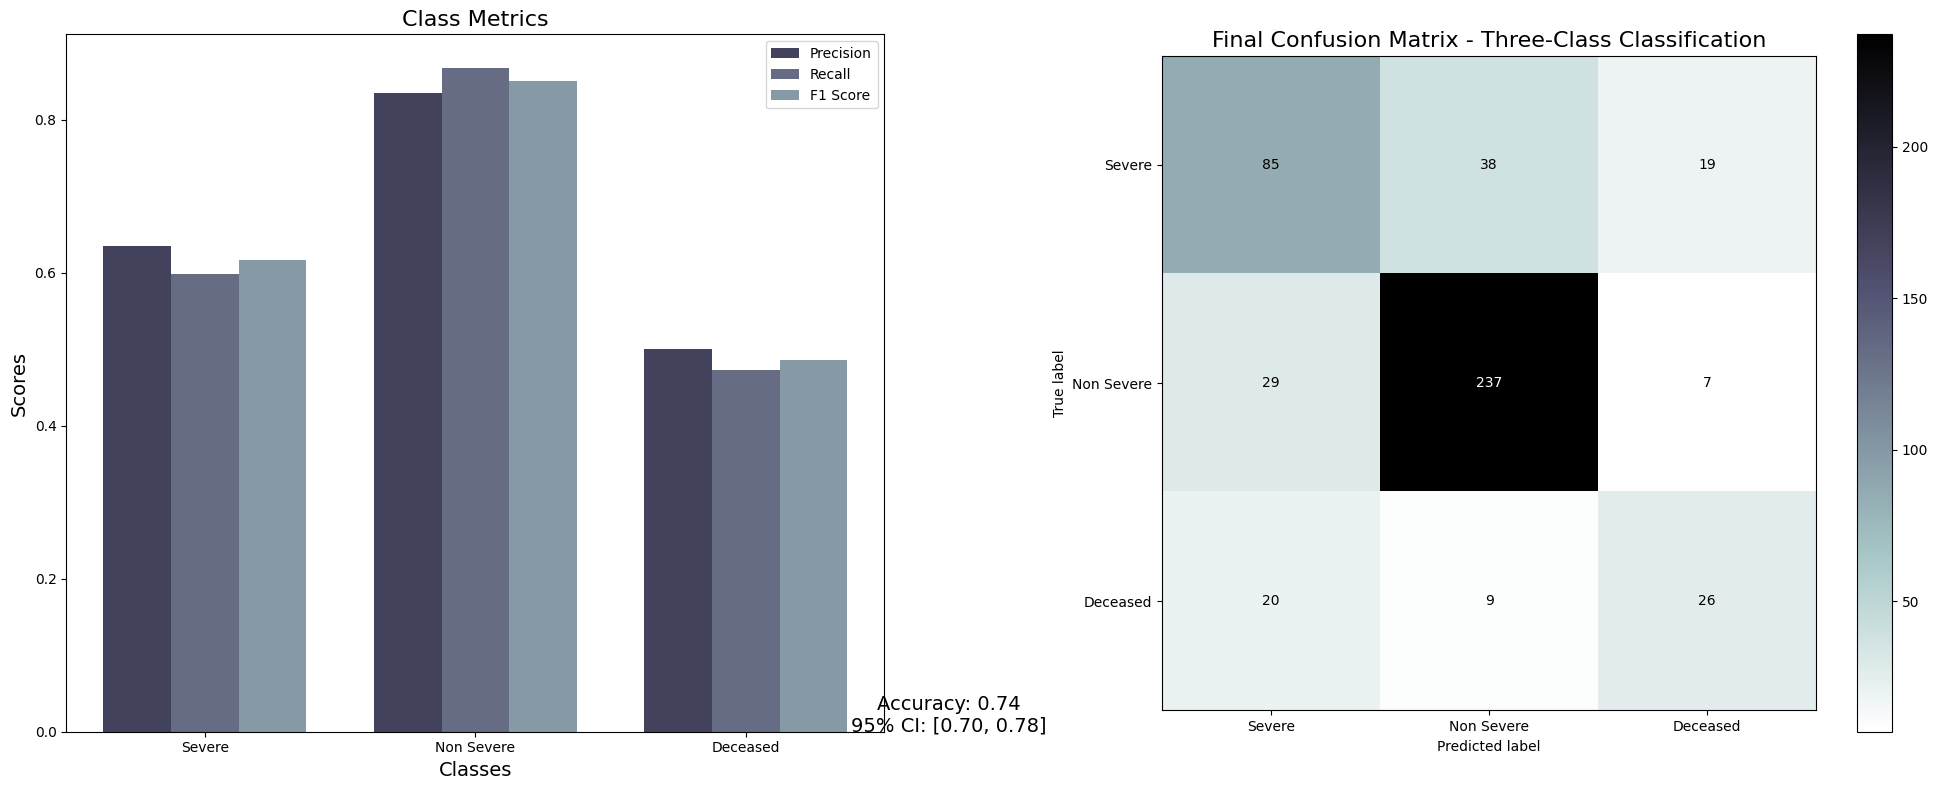

In [ ]:
# Function to build the model
def build_model(input_dim, dropout_rate=0.2, optimizer='adam'):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Bootstrap function for calculating CI of accuracy
def bootstrap_accuracy(y_true, y_pred, n_iterations=1000):
    bootstrap_accuracies = []
    for i in range(n_iterations):
        indices = resample(np.arange(len(y_true)), replace=True)
        sampled_y_true = y_true[indices]
        sampled_y_pred = y_pred[indices]
        bootstrap_accuracies.append(accuracy_score(sampled_y_true, sampled_y_pred))
    return np.percentile(bootstrap_accuracies, [2.5, 97.5])

# K-fold cross-validation parameters
n_splits = 8
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Variables to store aggregated results
all_true_labels = []
all_pred_labels = []
total_scores = []

# Perform k-fold cross-validation
for train_idx, test_idx in kfold.split(X, y):
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X.iloc[train_idx])
    X_test_fold = scaler.transform(X.iloc[test_idx])
    smote = SMOTE(random_state=42)
    X_train_fold_sm, y_train_fold_sm = smote.fit_resample(X_train_fold, y.iloc[train_idx])

    model = build_model(input_dim=X_train_fold_sm.shape[1])
    model.fit(X_train_fold_sm, y_train_fold_sm, epochs=10, batch_size=32, verbose=0)

    y_pred = np.argmax(model.predict(X_test_fold), axis=1)
    scores = accuracy_score(y.iloc[test_idx], y_pred)
    total_scores.append(scores)

    all_true_labels.extend(y.iloc[test_idx])
    all_pred_labels.extend(y_pred)

# Calculate overall metrics
overall_accuracy = np.mean(total_scores)
overall_precision = precision_score(all_true_labels, all_pred_labels, average=None)
overall_recall = recall_score(all_true_labels, all_pred_labels, average=None)
overall_f1 = f1_score(all_true_labels, all_pred_labels, average=None)
overall_confusion_matrix = confusion_matrix(all_true_labels, all_pred_labels)

# Calculate 95% Confidence Interval for the overall accuracy
confidence_interval = bootstrap_accuracy(np.array(all_true_labels), np.array(all_pred_labels))

# Visualization
class_labels = ['Severe', 'Non Severe', 'Deceased']
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
bone_palette = plt.cm.bone(np.linspace(0.3, 0.6, 3))

# Plotting metrics
bar_width = 0.25
index = np.arange(len(class_labels))

axes[0].bar(index, overall_precision, bar_width, color=bone_palette[0], label='Precision')
axes[0].bar(index + bar_width, overall_recall, bar_width, color=bone_palette[1], label='Recall')
axes[0].bar(index + 2 * bar_width, overall_f1, bar_width, color=bone_palette[2], label='F1 Score')

axes[0].set_xlabel('Classes', fontsize=14)
axes[0].set_ylabel('Scores', fontsize=14)
axes[0].set_title('Class Metrics', fontsize=16)
axes[0].set_xticks(index + bar_width)
axes[0].set_xticklabels(class_labels)
axes[0].legend()

# Adding CI and overall accuracy to the plot
axes[0].text(len(class_labels), 0, f'Accuracy: {overall_accuracy:.2f}\n95% CI: [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]', fontsize=14, ha='center')

# Confusion Matrix Display
conf_matrix_disp = ConfusionMatrixDisplay(confusion_matrix=overall_confusion_matrix, display_labels=class_labels)
conf_matrix_disp.plot(cmap=plt.cm.bone_r, ax=axes[1], colorbar=True)
axes[1].set_title('Final Confusion Matrix - Three-Class Classification', fontsize=16)

plt.tight_layout()
plt.show()


2/2 [==============================] - 0s 10ms/step


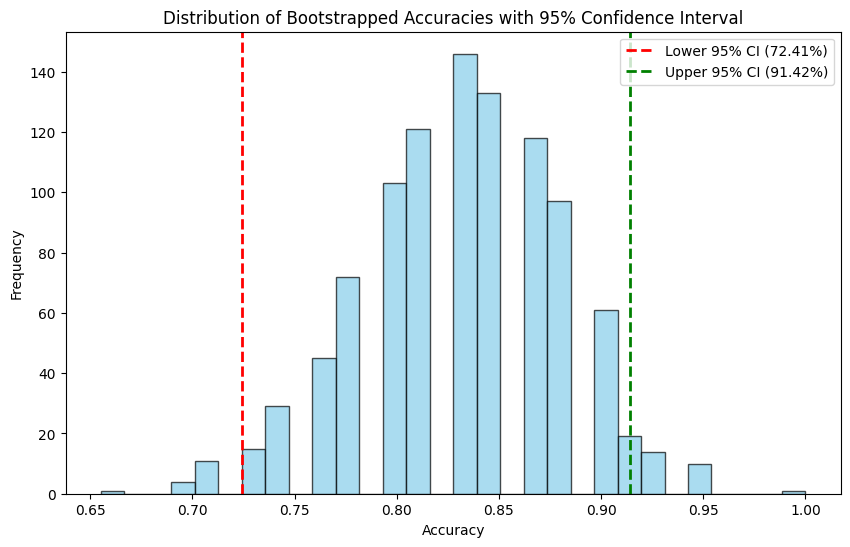

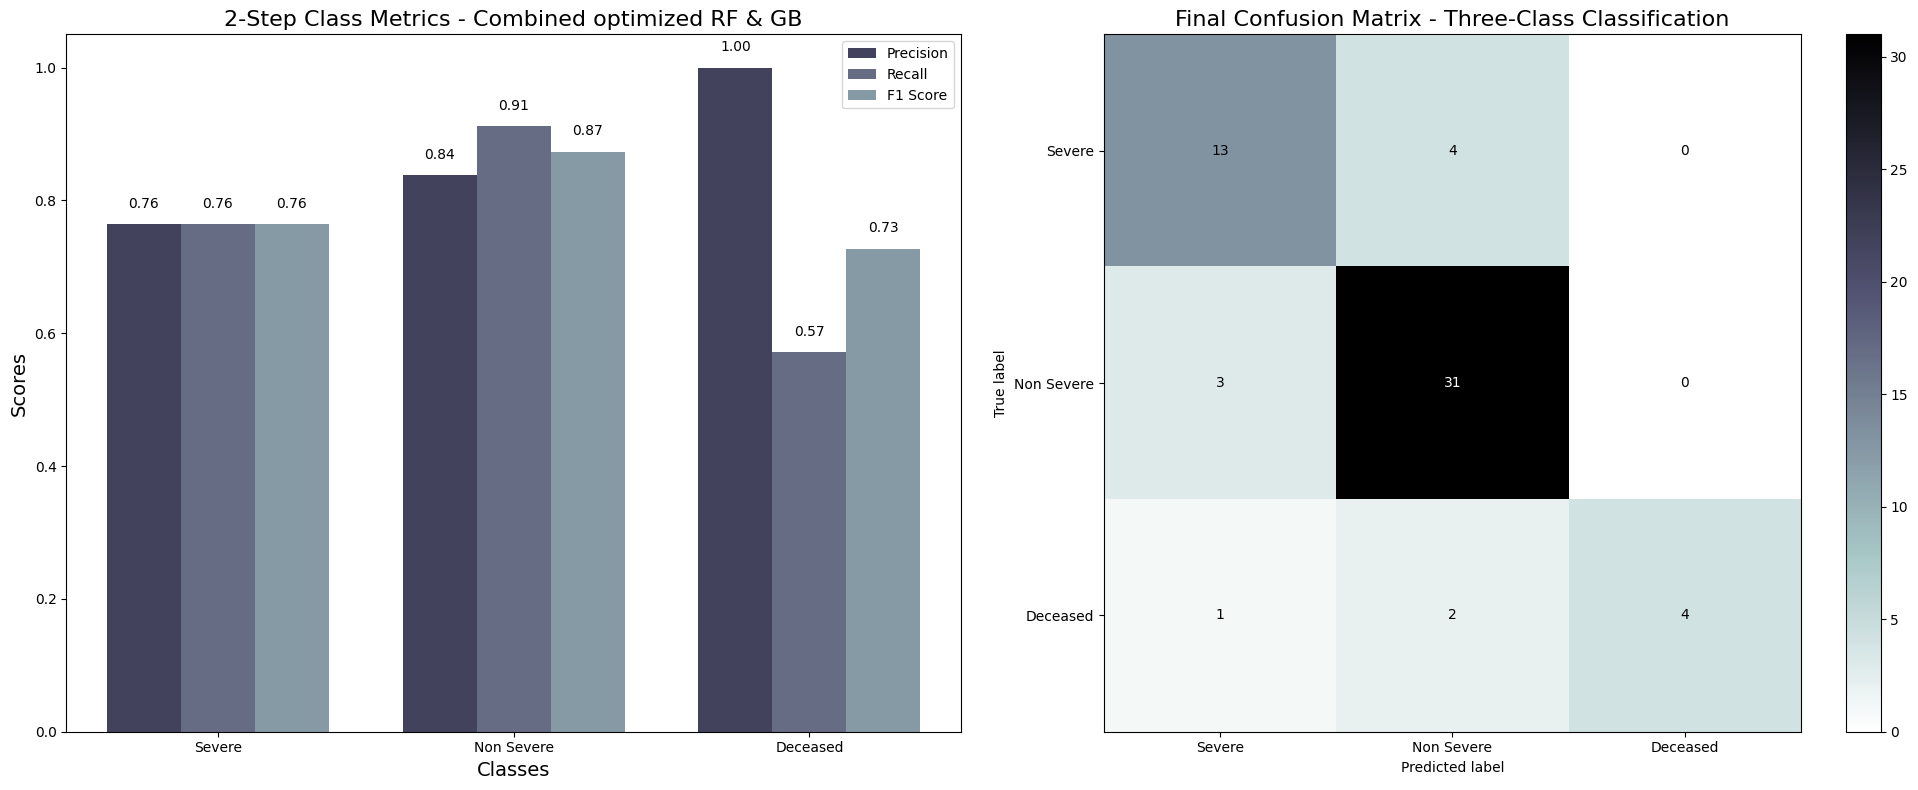

In [ ]:
# Function to perform bootstrapping on accuracies
def bootstrap_accuracies(y_true, y_pred, n_iterations=1000):
    accuracies = []
    for _ in range(n_iterations):
        indices = resample(np.arange(len(y_true)), replace=True)
        y_true_sample = y_true[indices]
        y_pred_sample = y_pred[indices]
        accuracies.append(accuracy_score(y_true_sample, y_pred_sample))
    return accuracies

y_true = y.iloc[test_idx].to_numpy() 
y_pred = np.argmax(model.predict(X_test_fold), axis=1)

# Bootstrap the accuracies
bootstrap_accuracies = bootstrap_accuracies(y_true, y_pred)

# Calculate 95% confidence intervals
confidence_lower = np.percentile(bootstrap_accuracies, 2.5)
confidence_upper = np.percentile(bootstrap_accuracies, 97.5)

# Plotting the distribution of bootstrapped accuracies
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_accuracies, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(confidence_lower, color='red', linestyle='dashed', linewidth=2, label=f'Lower 95% CI ({confidence_lower:.2%})')
plt.axvline(confidence_upper, color='green', linestyle='dashed', linewidth=2, label=f'Upper 95% CI ({confidence_upper:.2%})')
plt.title('Distribution of Bootstrapped Accuracies with 95% Confidence Interval')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Calculate detailed evaluation metrics
accuracy_final = accuracy_score(y_true, y_pred)
precision_final = precision_score(y_true, y_pred, average=None)
recall_final = recall_score(y_true, y_pred, average=None)
f1_final = f1_score(y_true, y_pred, average=None)
conf_matrix_final = confusion_matrix(y_true, y_pred)

class_labels = ['Severe', 'Non Severe', 'Deceased']

# Creating a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
bone_palette = plt.cm.bone(np.linspace(0.3, 0.6, 3))

bar_width = 0.25
index = np.arange(len(class_labels))

# Plotting precision, recall, and F1-score for each class
axes[0].bar(index, precision_final, bar_width, color=bone_palette[0], label='Precision')
axes[0].bar(index + bar_width, recall_final, bar_width, color=bone_palette[1], label='Recall')
axes[0].bar(index + 2 * bar_width, f1_final, bar_width, color=bone_palette[2], label='F1 Score')
axes[0].set_xlabel('Classes', fontsize=14)
axes[0].set_ylabel('Scores', fontsize=14)
axes[0].set_title('2-Step Class Metrics - Combined optimized RF & GB', fontsize=16)
axes[0].set_xticks(index + bar_width)
axes[0].set_xticklabels(class_labels)
axes[0].legend()

# Annotations for clarity
for i in range(len(class_labels)):
    axes[0].text(i, precision_final[i] + 0.02, f'{precision_final[i]:.2f}', ha='center', va='bottom')
    axes[0].text(i + bar_width, recall_final[i] + 0.02, f'{recall_final[i]:.2f}', ha='center', va='bottom')
    axes[0].text(i + 2 * bar_width, f1_final[i] + 0.02, f'{f1_final[i]:.2f}', ha='center', va='bottom')

# Confusion Matrix Display
conf_matrix_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_final, display_labels=class_labels)
conf_matrix_disp.plot(cmap=plt.cm.bone_r, ax=axes[1], colorbar=True)
axes[1].set_title('Final Confusion Matrix - Three-Class Classification', fontsize=16)

plt.tight_layout()
plt.show()


In [ ]:
# Function to perform bootstrapping on accuracies
def bootstrap_accuracies(y_true, y_pred, n_iterations=1000):
    accuracies = []
    for _ in range(n_iterations):
        indices = resample(np.arange(len(y_true)), replace=True)
        y_true_sample = y_true[indices]
        y_pred_sample = y_pred[indices]
        accuracies.append(accuracy_score(y_true_sample, y_pred_sample))
    return accuracies

y_true = y.iloc[test_idx].to_numpy()  
y_pred = np.argmax(model.predict(X_test_fold), axis=1)  

# Use the fixed bootstrap function
bootstrap_results = bootstrap_accuracies(y_true, y_pred)
confidence_lower = np.percentile(bootstrap_results, 2.5)
confidence_upper = np.percentile(bootstrap_results, 97.5)

# Print or plot the confidence intervals
print("95% Confidence Interval for Accuracies:", confidence_lower, confidence_upper)


2/2 [==============================] - 0s 12ms/step
95% Confidence Interval for Accuracies: 0.7241379310344828 0.9310344827586207


In [ ]:
# Function to perform bootstrapping on accuracies
def bootstrap_accuracies(y_true, y_pred, n_iterations=1000):
    accuracies = []
    for _ in range(n_iterations):
        indices = resample(np.arange(len(y_true)), replace=True)
        y_true_sample = y_true[indices]
        y_pred_sample = y_pred[indices]
        accuracies.append(accuracy_score(y_true_sample, y_pred_sample))
    return accuracies


In [ ]:
def build_model(input_dim, dropout_rate=0.2, optimizer='adam'):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Define k-fold cross-validation parameters
n_splits =2
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize storage for aggregated report values
# Adjust for multiclass (three classes)
aggregated_report = {metric: {label: [] for label in range(3)} for metric in ['precision', 'recall', 'f1-score', 'support']}

# Variables to store aggregated results
total_scores = []
confusion_matrices = []
classification_reports = []
fold_no = 1

# Perform k-fold cross-validation
for train_idx, test_idx in kfold.split(X, y):
    # Scale data within each fold
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X.iloc[train_idx])
    X_test_fold = scaler.transform(X.iloc[test_idx])

    # Apply SMOTE to the training data within each fold
    smote = SMOTE(random_state=42)
    X_train_fold_sm, y_train_fold_sm = smote.fit_resample(X_train_fold, y.iloc[train_idx])

    # Train and evaluate the model
    model = build_model(input_dim=X_train_fold_sm.shape[1], dropout_rate=0.1, optimizer='adam')
    print(f'Training on fold {fold_no}...')
    model.fit(X_train_fold_sm, y_train_fold_sm, epochs=10, batch_size=64, verbose=1)

    # Evaluate the model
    y_pred = model.predict(X_test_fold)
    y_pred_classes = np.argmax(y_pred, axis=1)
    scores = accuracy_score(y.iloc[test_idx], y_pred_classes)
    total_scores.append(scores)
    confusion_matrices.append(confusion_matrix(y.iloc[test_idx], y_pred_classes))
    classification_reports.append(classification_report(y.iloc[test_idx], y_pred_classes, output_dict=True))

    print(f'Score for fold {fold_no}: Accuracy of {scores}')
    fold_no += 1

# Aggregate and print classification reports
for report in classification_reports:
    for label in range(3):
        for metric in ['precision', 'recall', 'f1-score']:
            aggregated_report[metric][label].append(report[str(label)][metric])
        aggregated_report['support'][label].append(report[str(label)]['support'])

final_report = {}
for metric, labels in aggregated_report.items():
    final_report[metric] = {}
    for label, values in labels.items():
        final_report[metric][label] = np.mean(values) if metric != 'support' else sum(values)  # Average metrics except for 'support'

# Print the aggregated classification report
print('Aggregated Classification Report:')
for metric, labels in final_report.items():
    print(f'{metric.upper()}:')
    for label, value in labels.items():
        print(f'  Label {label}: {value:.2f}')


Training on fold 1...
Epoch 1/30
7/7 [==============================] - 1s 7ms/step - loss: 1.1634 - accuracy: 0.3848
Epoch 2/30
7/7 [==============================] - 0s 6ms/step - loss: 0.8830 - accuracy: 0.6078
Epoch 3/30
7/7 [==============================] - 0s 8ms/step - loss: 0.7388 - accuracy: 0.7059
Epoch 4/30
7/7 [==============================] - 0s 6ms/step - loss: 0.5975 - accuracy: 0.8431
Epoch 5/30
7/7 [==============================] - 0s 7ms/step - loss: 0.5039 - accuracy: 0.8799
Epoch 6/30
7/7 [==============================] - 0s 6ms/step - loss: 0.4090 - accuracy: 0.9020
Epoch 7/30
7/7 [==============================] - 0s 7ms/step - loss: 0.3318 - accuracy: 0.9314
Epoch 8/30
7/7 [==============================] - 0s 6ms/step - loss: 0.2647 - accuracy: 0.9485
Epoch 9/30
7/7 [==============================] - 0s 5ms/step - loss: 0.2143 - accuracy: 0.9632
Epoch 10/30
7/7 [==============================] - 0s 5ms/step - loss: 0.1776 - accuracy: 0.9632
Epoch 11/30
7/7 [

In [ ]:
%matplotlib inline

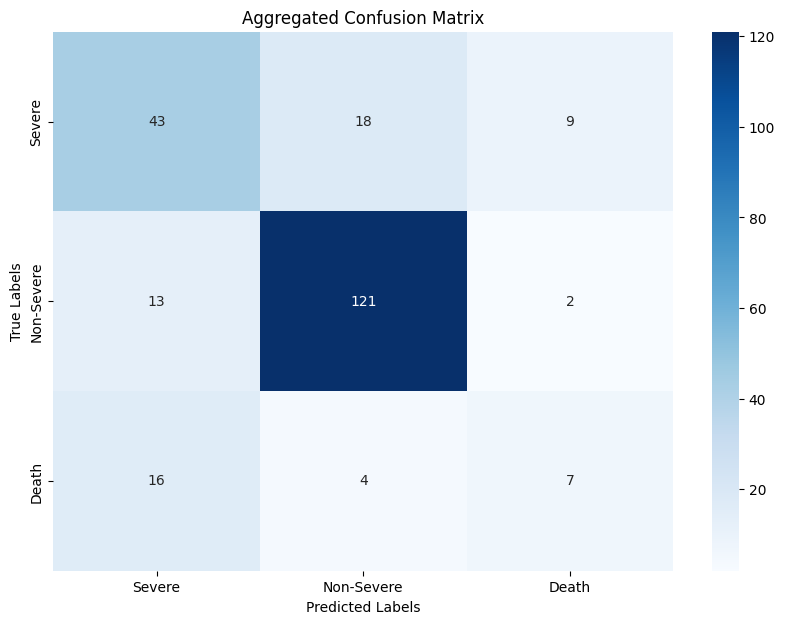

In [24]:
plt.figure(figsize=(10, 7))
mean_confusion_matrix = np.mean(confusion_matrices, axis=0).astype(int)
sns.heatmap(mean_confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Severe', 'Non-Severe', 'Death'],
            yticklabels=['Severe', 'Non-Severe', 'Death'])
plt.title('Aggregated Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

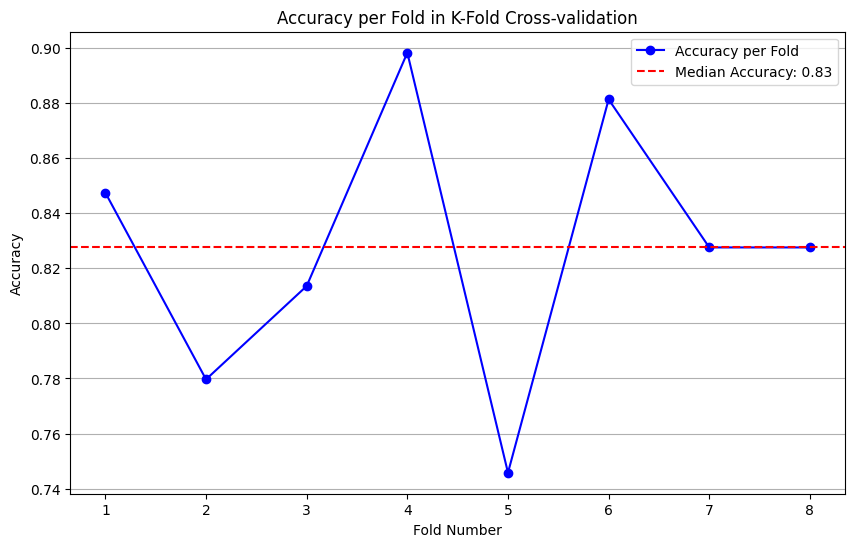

In [ ]:
fold_numbers = list(range(1, n_splits + 1))
median_accuracy = np.median(total_scores)

plt.figure(figsize=(10, 6))
plt.plot(fold_numbers, total_scores, '-o', color='blue', label='Accuracy per Fold')
plt.axhline(y=median_accuracy, color='red', linestyle='--', label=f'Median Accuracy: {median_accuracy:.2f}')

plt.title('Accuracy per Fold in K-Fold Cross-validation')
plt.xlabel('Fold Number')
plt.ylabel('Accuracy')
plt.xticks(fold_numbers)
plt.legend()
plt.grid(axis='y')
plt.show()

In [ ]:
for metric in metrics:
    print(f"{metric}: {final_report[metric]}")
    if len(final_report[metric]) != 3:
        print(f"Warning: Missing data for {metric}. Expected 3 classes, got {len(final_report[metric])}.")


precision: {0: 0.7654251918158568, 1: 0.9237047562652401, 2: 0.572695707070707}
recall: {0: 0.7610294117647058, 1: 0.9120798319327731, 2: 0.5892857142857142}
f1-score: {0: 0.7562949593302893, 1: 0.916720960277579, 2: 0.5625068558892088}


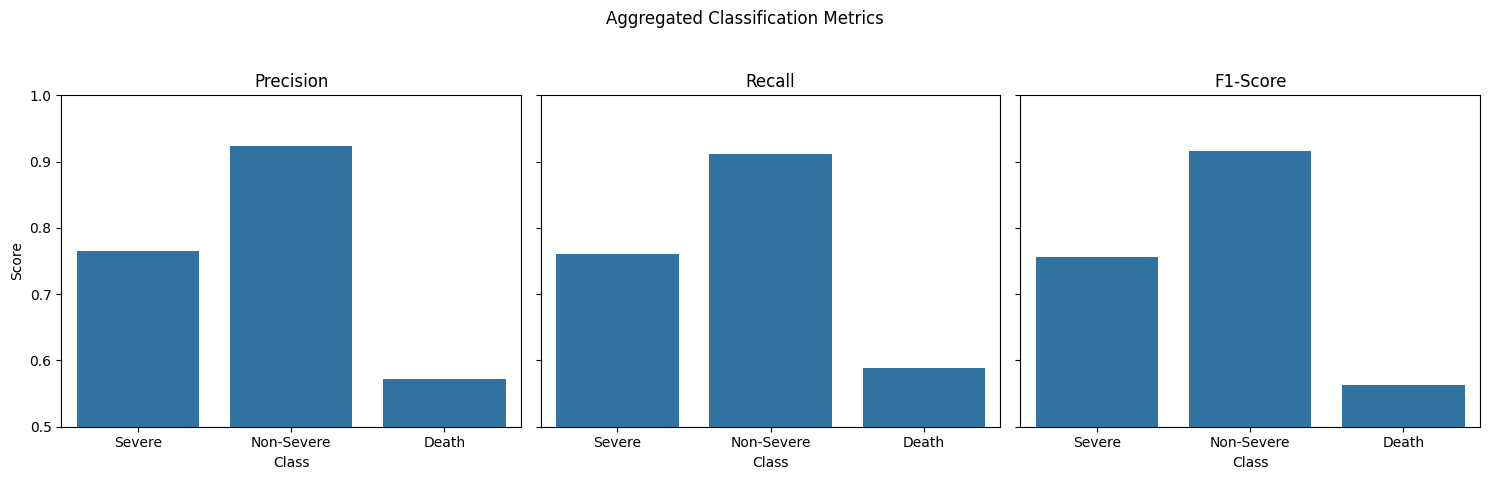

In [ ]:
metrics = ['precision', 'recall', 'f1-score']
class_labels = ['Severe', 'Non-Severe', 'Death']

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
fig.suptitle('Aggregated Classification Metrics')

# Loop through each metric and create a bar plot
for i, metric in enumerate(metrics):
    # Retrieve values for each class
    values = [final_report[metric][label] for label in range(3)]
    sns.barplot(ax=axes[i], x=class_labels, y=values)
    axes[i].set_title(metric.title())
    axes[i].set_ylim(0.5, 1)
    axes[i].set_ylabel('Score')
    axes[i].set_xlabel('Class')

# Adjust layout for better readability and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
# Evaluate model on the original, unshuffled test set
original_scores = model.evaluate(X_test_np, y_test, verbose=0)
original_accuracy = original_scores[1]

In [ ]:
# Check the computed feature importances
print(sorted_features)  
# This will print out the features sorted by their importance

[('ABSLYMPHOCYTES', -0.004716992378234863), ('FERRITIN', -0.009433954954147339), ('AGE', -0.02358490228652954), ('GENDER', -0.02358490228652954), ('Systolic_BP', -0.02358490228652954), ('Diastolic_BP', -0.02358490228652954), ('PULSE RATE', -0.02358490228652954), ('TEMP', -0.02358490228652954), ('PH', -0.02358490228652954), ('PO2', -0.02358490228652954), ('PCO2', -0.02358490228652954), ('HCO3', -0.02358490228652954), ('WHO score', -0.02358490228652954), ('WBC', -0.02358490228652954), ('LDH', -0.02358490228652954), ('CPK', -0.02358490228652954), ('CRP', -0.02358490228652954), ('PERLYMPHOCYTES', -0.02358490228652954), ('Hb', -0.02358490228652954), ('PLT', -0.02358490228652954), ('INR', -0.02358490228652954), ('APTT', -0.02358490228652954), ('D-DIMERS_cleaned', -0.02358490228652954), ('K', -0.02358490228652954), ('NA', -0.02358490228652954), ('UREA', -0.02358490228652954), ('CR', -0.02358490228652954), ('BIL', -0.02358490228652954), ('DIRECT BIL', -0.02358490228652954), ('SGOT', -0.0235849

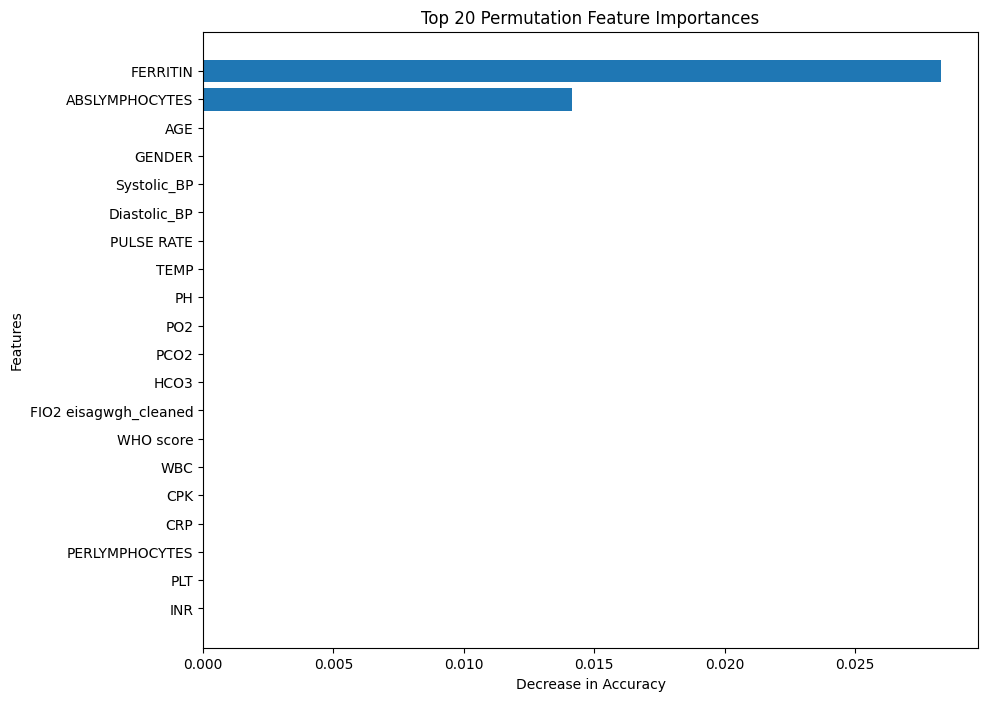

In [ ]:
feature_names = dataset.columns.drop('Outcome_numerical')  
# Convert X_test to a NumPy array
X_test_np = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test

# Recalculate feature importance based on shuffled features
feature_importance = {}
for i, feature in enumerate(feature_names):
    # Copy the original test set as a NumPy array
    X_test_shuffled = X_test_np.copy()

    # Shuffle one feature: now using NumPy array so this works correctly
    np.random.shuffle(X_test_shuffled[:, i])

    # Evaluate model with the shuffled feature
    shuffled_scores = model.evaluate(X_test_shuffled, y_test, verbose=0)
    shuffled_accuracy = shuffled_scores[1]

    # Calculate importance as the decrease in accuracy
    feature_importance[feature] = original_accuracy - shuffled_accuracy
# Sort features by importance and select the top 20
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
top_20_features = sorted_features[:20]

# Unpack features and their importances for plotting
features, importances = zip(*top_20_features)

# Plotting the top 20 permutation feature importances
plt.figure(figsize=(10, 8))
plt.barh(features, importances)
plt.xlabel('Decrease in Accuracy')
plt.ylabel('Features')
plt.title('Top 20 Permutation Feature Importances')
plt.gca().invert_yaxis()  # Ensure the most important feature is at the top
plt.show()



Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


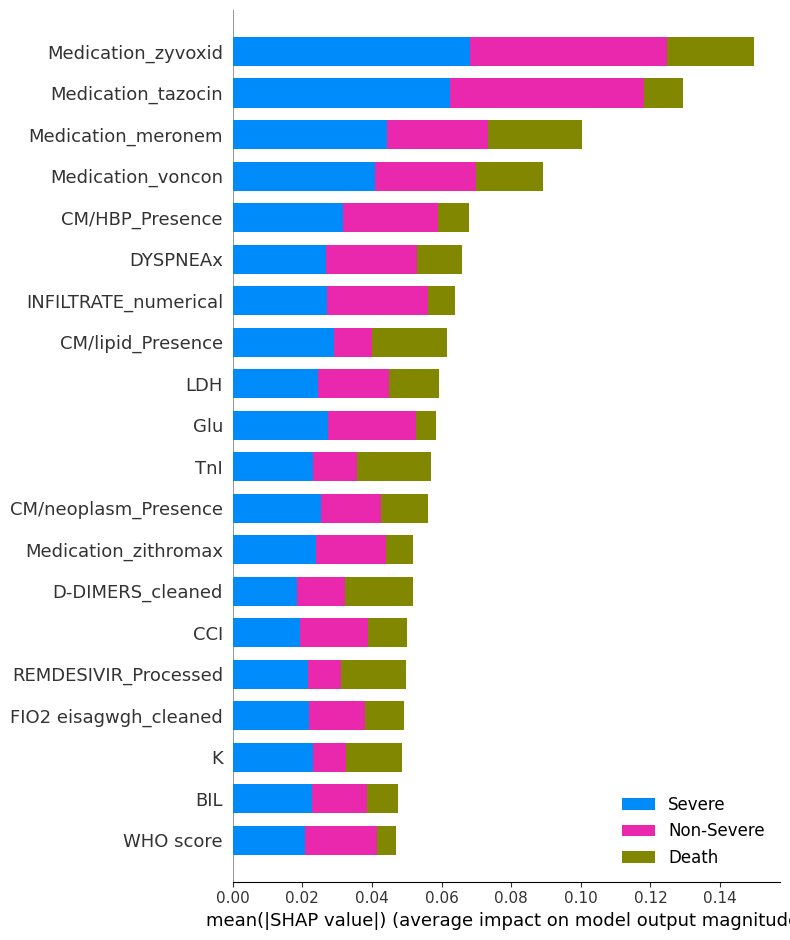

In [ ]:
import shap

# Convert X_test to a NumPy array
X_test_np = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test
# But for background data, it's often better to use the original scale for interpretability
background_data = X_train_scaled[:subset_size]
subset_size = 470
explainer = shap.DeepExplainer(model, background_data)

# Calculate SHAP values for a subset of the test data.
shap_values = explainer.shap_values(X_test_scaled[:subset_size])

feature_names = dataset.columns.drop('Outcome_numerical')

# Plot the feature importance summary
shap.summary_plot(shap_values, X_test_np[:subset_size], feature_names=feature_names.tolist(), class_names=['Severe', 'Non-Severe', 'Death'])


In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 8.9 MB/s eta 0:00:00
